In [1]:
from classy import Class
import numpy as np
import matplotlib.pyplot as plt
from math import sqrt
import scipy.integrate as sc
#plt.rcParams.update({   "text.usetex": True,})

In [2]:
kvec = [1e-1, 1, 10]
cosmo = Class()
cosmo.set({'H0':70, 'Omega_b':0.05, 'Omega_cdm':0.25, 'k_output_values':str(kvec).strip('[]'), 
           'output':'tCl, lCl, dTk, vTk, pCl', 'lensing':'yes',
          'N_ncdm':1, 'm_ncdm':10, 'gauge':'synchronous'})
cosmo.compute()

dict_keys(['z', 'proper time [Gyr]', 'conf. time [Mpc]', 'H [1/Mpc]', 'comov. dist.', 'ang.diam.dist.', 'lum. dist.', 'comov.snd.hrz.', '(.)rho_g', '(.)rho_b', '(.)rho_cdm', '(.)rho_ncdm[0]', '(.)p_ncdm[0]', '(.)rho_lambda', '(.)rho_ur', '(.)rho_crit', '(.)rho_tot', '(.)p_tot', '(.)p_tot_prime', 'gr.fac. D', 'gr.fac. f'])
65.4957555323583


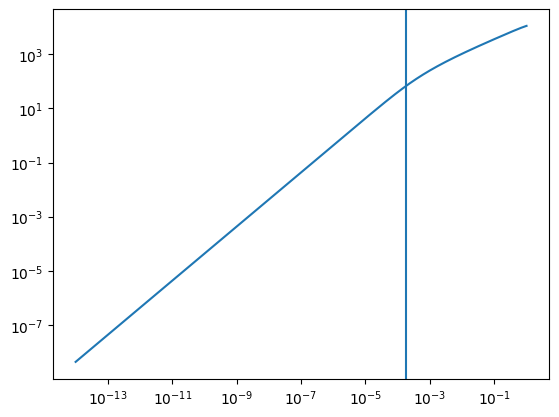

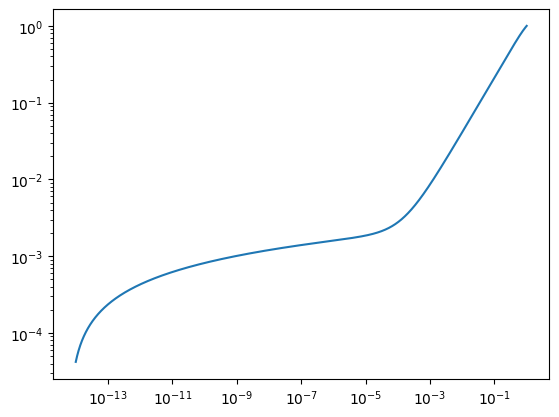

In [3]:
bg = cosmo.get_background()
print(bg.keys())
a = 1/(1 + bg['z'])
tau = bg['conf. time [Mpc]']
plt.loglog(a, tau)
a_eq = cosmo.get_current_derived_parameters(['a_eq'])['a_eq']
plt.axvline(a_eq)
print(np.interp(a_eq, a, tau))

plt.figure()
plt.loglog(a, bg['gr.fac. D'])

dict_keys(['tau [Mpc]', 'a', 'delta_g', 'theta_g', 'shear_g', 'pol0_g', 'pol1_g', 'pol2_g', 'delta_b', 'theta_b', 'psi', 'phi', 'delta_ur', 'theta_ur', 'shear_ur', 'delta_cdm', 'theta_cdm', 'delta_ncdm[0]', 'theta_ncdm[0]', 'shear_ncdm[0]', 'cs2_ncdm[0]'])


Text(0.5, 1.0, 'k = 1 1/Mpc')

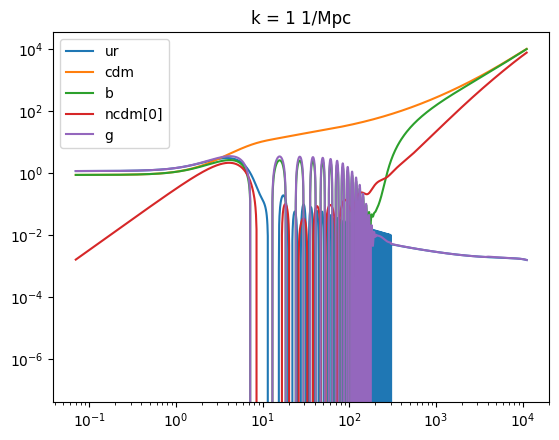

In [4]:
pts = cosmo.get_perturbations()['scalar']
index_k = 1
pts0 = pts[index_k]
print(pts0.keys())
for species in ['ur', 'cdm', 'b', 'ncdm[0]', 'g']:
    delta = pts0['delta_' + species]
    plt.loglog(pts0['tau [Mpc]'], -delta, label=species)
plt.legend()
plt.title(f'k = {kvec[index_k]} 1/Mpc')

In [5]:
# all output er i newtonian gauge af historiske årsager du kan overveje at udkommetnere gaugetransformation i koden senere.

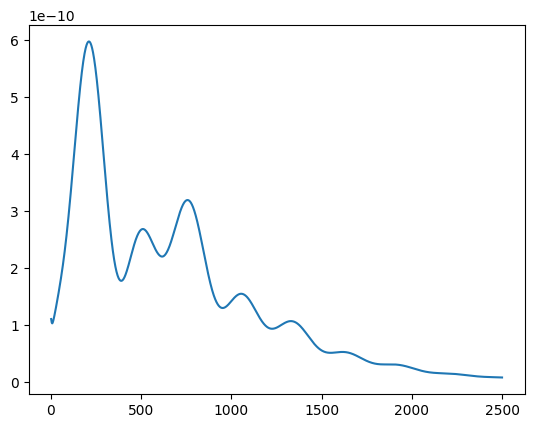

In [6]:
cl_lensed = cosmo.lensed_cl()
l = cl_lensed['ell'][2:]
factor = l*(l + 1)/(2*np.pi)
plt.plot(l, factor*cl_lensed['tt'][2:])

In [28]:
H0 = 70 / (3 * 1e5) # i 1/Mpc

a0 = 1e-14 
aend = 1 
steps = 4_000
Omega_lambda = 0.74 - 2 * 1e-5
Omega_M = 0.26- 2 * 1e-5
Omega_R = 4 * 1e-5
a2 = np.linspace(a0,aend,steps)

# udregning af Friedmanligningen
def H(a):
    return H0 * np.sqrt(Omega_lambda + Omega_M /( a **3) + Omega_R /( a**4)) 

def f(a,y):
    #a = t
    tau = y[0]
    d_tau = 1 / (a ** 2 * H(a))
    return np.array(d_tau)

tau0 = 1/H0 * Omega_R ** (-0.5) * a0
sol1 = sc.solve_ivp(f,t_span=[a0,aend],y0=[tau0],t_eval=a2) 

tau2 =sol1.y[0]
print(f"{tau[-1]=}")

print(len(tau2))

tau[-1]=11145.528946647506
4000


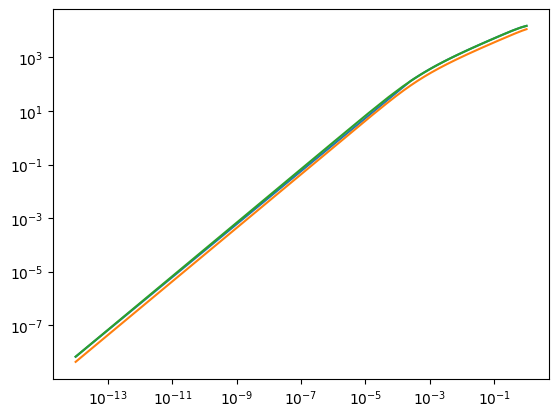

In [32]:
plt.loglog(a2,tau2)
#plt.xlabel(r"$a(\tau)$",rotation=0)
#plt.ylabel(r"$\tau$",rotation=0)
#plt.show()

plt.loglog(a,tau)
#plt.xlim([1e-3,1])
#plt.loglog(a3,tau3)

delta_cb_0=-0.8533333333333333
delta_cb_0=-0.8533333333333333
dict_keys(['tau [Mpc]', 'a', 'delta_g', 'theta_g', 'shear_g', 'pol0_g', 'pol1_g', 'pol2_g', 'delta_b', 'theta_b', 'psi', 'phi', 'delta_ur', 'theta_ur', 'shear_ur', 'delta_cdm', 'theta_cdm', 'delta_ncdm[0]', 'theta_ncdm[0]', 'shear_ncdm[0]', 'cs2_ncdm[0]'])
11145.528946647506
success


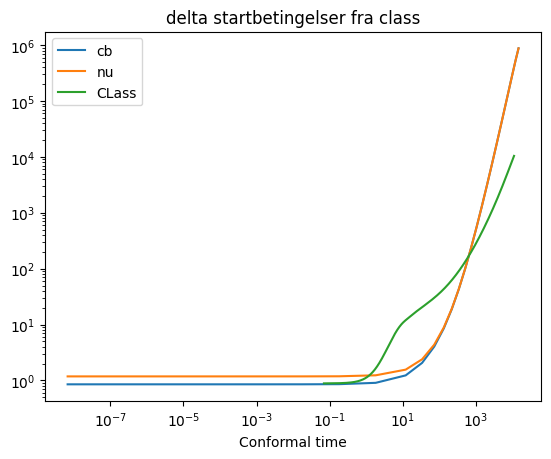

In [101]:
#print(type(a))
#print(type(tau))
#H=100
#x = np.array([i/10 for i in range(H+1)])
#y = x**2
#plt.loglog(x,y)

# nu skal jeg bare have nogle start værdier

H0 = 70 / (3*1e5) # i 1/Mpc
cs = 1350 * 3 * 1e-20 # det bud. jeg tog den værdi de havde angivet i artiklen og oversatte den til Mpc

C = 0.24 # dimensionsløs faktor til startværdierne fra B&M. 

k = index_k
N_nu = 3
R_nu = ((8/(7*N_nu))*(11/4)**(4/3) + 1 )**(-1)
R_nu = 0
delta_gamma = -2 / 3 * C * (k * tau[0])**2
delta_nu_0 = delta_gamma
delta_cb_0 = 4 / 3 * delta_gamma # *2 # muligvis et spørgsmål her er om delta_cb = delta_c + delta_b
theta_cb_0 = -1/18 * (k**4 * tau[0] ** 3)
theta_nu_0 = (23+4*R_nu)/(6*(15+4*R_nu)) * C * (k*tau[0])**2

# kvantemekanik tallet
R_nu = 0
psi = 20 * C / (15 + 4 * R_nu)
theta_nu_0 =  0.5 * (k*k*tau[0]) * psi
theta_cb_0 = theta_nu_0 
delta_gamma = -2 * psi 
delta_nu_0 = delta_gamma
delta_cb_0 = 4/3 * delta_gamma
phi = psi * (1 + R_nu)

print(f"{delta_cb_0=}")
#delta_cb_0 = pts0['delta_' + "cdm"][0]
print(f"{delta_cb_0=}")
theta_cb_0 = pts0['theta_cdm'][0]
theta_nu_0 = pts0['theta_ur'][0]
delta_nu_0 = pts0['delta_ur'][0]
psi = pts0['psi'][0]
a0 = a[0]
print(pts0.keys())
y0 = np.array([a0,delta_cb_0,theta_cb_0,delta_nu_0,theta_nu_0])

t_start = tau2[0]
t_end = tau2[-1]
t_span = np.array([t_start,t_end])

def f(t,y): 
    # her er t tau
    a_3 = y[0]
    #if t == tau[0]:
        #assert(k/ H(a) <1)
        #print(a)
        
    delta_cb = y[1]
    theta_cb = y[2]
    delta_nu = y[3]
    theta_nu = y[4]
    #print(a_3)
    #print(H(1))
    #print(H(a_3))
    d_a_dtau = a_3**2 * H(a_3)
    # poisson
    Omega_M_reel = Omega_M / ( a_3**3 * Omega_lambda + Omega_M + Omega_R / a_3)
    nabla2phi =(3/2) * H(a_3) ** 2  * Omega_M_reel * a_3**2  *  (delta_nu + delta_cb)
    
    d_delta_cb_dtau = - theta_cb
    
    d_theta_cb_dtau = - a_3 * H(a_3) * theta_cb -  nabla2phi
    
    d_delta_nu_dtau = - theta_nu
    
    d_theta_nu_dtau = - a_3 * H(a_3) * theta_nu - nabla2phi - k*k * (cs*cs ) * delta_nu
    
    return [d_a_dtau,d_delta_cb_dtau,d_theta_cb_dtau,d_delta_nu_dtau,d_theta_nu_dtau]
    

sol2 = sc.solve_ivp(f,t_span,y0)#,t_eval = tau)

a3        = sol2.y[0]
delta_cb3 = sol2.y[1]
theta_cb3 = sol2.y[2]
delta_nu3 = sol2.y[3]
theta_nu3 = sol2.y[4]
tau3      = sol2.t
print(tau[-1])
#print(a)
print("success")
plt.loglog(tau3,-delta_cb3,label="cb")
plt.loglog(tau3,-delta_nu3,label="nu")
plt.title("delta"+ " startbetingelser fra class")
plt.loglog(pts0['tau [Mpc]'],-pts0['delta_' + "cdm"],label="CLass")
plt.xlabel("Conformal time")
plt.legend()

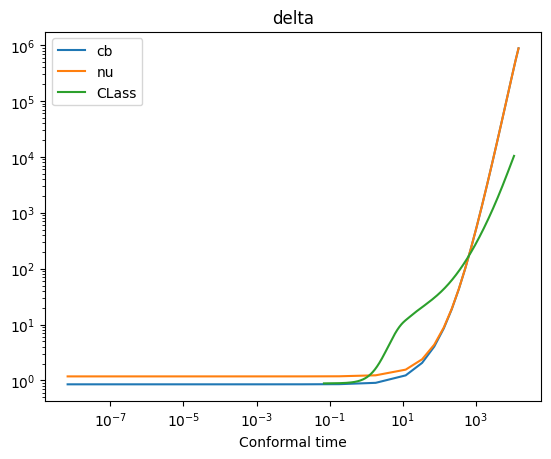

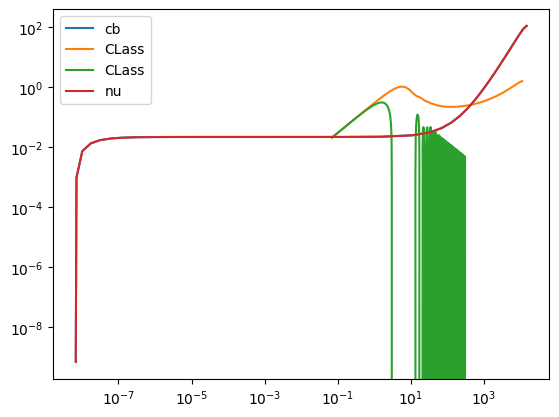

In [96]:
plt.loglog(tau3,theta_cb3,label="cb")
plt.loglog(pts0['tau [Mpc]'],pts0['theta_' + "cdm"],label="CLass")
plt.loglog(pts0['tau [Mpc]'],pts0['theta_' + "ur"],label="CLass")
plt.loglog(tau3,theta_nu3,label="nu")
plt.legend()

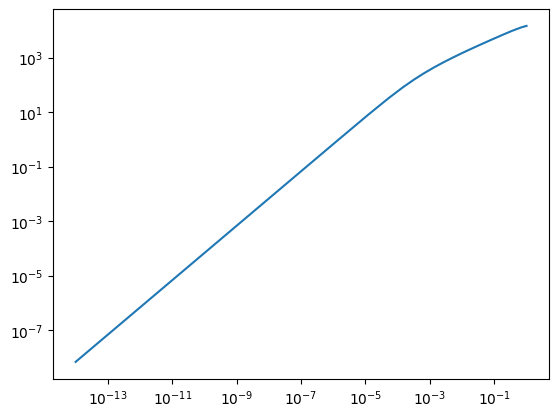

In [31]:
plt.loglog(a3,tau3)

dict_keys(['tau [Mpc]', 'a', 'delta_g', 'theta_g', 'shear_g', 'pol0_g', 'pol1_g', 'pol2_g', 'delta_b', 'theta_b', 'psi', 'phi', 'delta_ur', 'theta_ur', 'shear_ur', 'delta_cdm', 'theta_cdm', 'delta_ncdm[0]', 'theta_ncdm[0]', 'shear_ncdm[0]', 'cs2_ncdm[0]'])
11145.528946647506
success


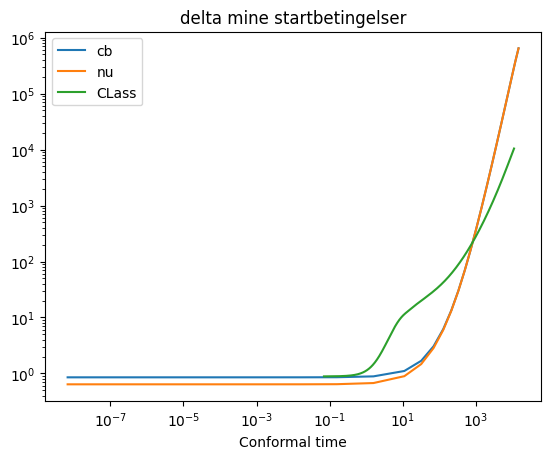

In [99]:
#print(type(a))
#print(type(tau))
#H=100
#x = np.array([i/10 for i in range(H+1)])
#y = x**2
#plt.loglog(x,y)

# nu skal jeg bare have nogle start værdier

H0 = 70 / (3*1e5) # i 1/Mpc
cs = 1350 * 3 * 1e-20 # det bud. jeg tog den værdi de havde angivet i artiklen og oversatte den til Mpc

C = 0.24 # dimensionsløs faktor til startværdierne fra B&M. 

k = index_k
N_nu = 3
R_nu = ((8/(7*N_nu))*(11/4)**(4/3) + 1 )**(-1)
R_nu = 0
delta_gamma = -2 / 3 * C * (k * tau[0])**2
delta_nu_0 = delta_gamma
delta_cb_0 = 4 / 3 * delta_gamma # *2 # muligvis et spørgsmål her er om delta_cb = delta_c + delta_b
theta_cb_0 = -1/18 * (k**4 * tau[0] ** 3)
theta_nu_0 = (23+4*R_nu)/(6*(15+4*R_nu)) * C * (k*tau[0])**2

# kvantemekanik tallet
R_nu = 0
psi = 20 * C / (15 + 4 * R_nu)
theta_nu_0 =  0.5 * (k*k*tau[0]) * psi
theta_cb_0 = theta_nu_0 
delta_gamma = -2 * psi 
delta_nu_0 = delta_gamma
delta_cb_0 = 4/3 * delta_gamma
phi = psi * (1 + R_nu)

#print(f"{delta_cb_0=}")
#delta_cb_0 = pts0['delta_' + "cdm"][0]
#print(f"{delta_cb_0=}")
#theta_cb_0 = pts0['theta_cdm'][0]
#theta_nu_0 = pts0['theta_ur'][0]
#delta_nu_0 = pts0['delta_ur'][0]
#psi = pts0['psi'][0]

print(pts0.keys())
y0 = np.array([a0,delta_cb_0,theta_cb_0,delta_nu_0,theta_nu_0])

t_start = tau2[0]
t_end = tau2[-1]
t_span = np.array([t_start,t_end])

def f(t,y): 
    # her er t tau
    a_3 = y[0]
    #if t == tau[0]:
        #assert(k/ H(a) <1)
        #print(a)
        
    delta_cb = y[1]
    theta_cb = y[2]
    delta_nu = y[3]
    theta_nu = y[4]
    #print(a_3)
    #print(H(1))
    #print(H(a_3))
    d_a_dtau = a_3**2 * H(a_3)
    # poisson
    Omega_M_reel = Omega_M / ( a_3**3 * Omega_lambda + Omega_M + Omega_R / a_3)
    nabla2phi =(3/2) * H(a_3) ** 2  * Omega_M_reel * a_3**2  *  (delta_nu + delta_cb)
    
    d_delta_cb_dtau = - theta_cb
    
    d_theta_cb_dtau = - a_3 * H(a_3) * theta_cb -  nabla2phi
    
    d_delta_nu_dtau = - theta_nu
    
    d_theta_nu_dtau = - a_3 * H(a_3) * theta_nu - nabla2phi - k*k * (cs*cs ) * delta_nu
    
    return [d_a_dtau,d_delta_cb_dtau,d_theta_cb_dtau,d_delta_nu_dtau,d_theta_nu_dtau]
    

sol2 = sc.solve_ivp(f,t_span,y0)#,t_eval = tau)

a3        = sol2.y[0]
delta_cb3 = sol2.y[1]
theta_cb3 = sol2.y[2]
delta_nu3 = sol2.y[3]
theta_nu3 = sol2.y[4]
tau3      = sol2.t
print(tau[-1])
#print(a)
print("success")
plt.loglog(tau3,-delta_cb3,label="cb")
plt.loglog(tau3,-delta_nu3,label="nu")
plt.title("delta" + " mine startbetingelser" )
plt.loglog(pts0['tau [Mpc]'],-pts0['delta_' + "cdm"],label="CLass")
plt.xlabel("Conformal time")
plt.legend()